# Informer Model - Traffic & Electricity benchmarks - First tests

- **Master Thesis**: *'Time Series Forecasting using Transformers'*
- **Author**: Andrés Carrillo López
- **Thesis Tutor**: Pablo Martínez Olmos

**Goal of this notebook**: Once retrieved the Electricity and Traffic benchmark datasets in aggregated format, the Informer model ([Beyond Efficient Transformer for Long Sequence Time-Series Forecasting](https://arxiv.org/abs/2012.07436)) Pytorch implementation by the original authors will be tested over them, by first specifying the correct data encoding parameters as well as model architecture and hyperparameters. Finally, after training the models, respective performance evaluation and attention / forecast visualization will be analyzed.

**Used model implementation info:**
- [Informer code repository](https://github.com/zhouhaoyi/Informer2020)
- [Informer Model paper](https://arxiv.org/abs/2012.07436)
- [Provided Examples](https://github.com/zhouhaoyi/Informer2020#colablink), [Colab sample notebook](https://colab.research.google.com/drive/1_X7O2BkFLvqyCdZzDZvV2MB0aAvYALLC).

<figure>
<center>
<img src='https://raw.githubusercontent.com/zhouhaoyi/Informer2020/main/img/informer.png' width="450" height="300"/>
<figcaption>Informer architecture (Haoyi et al, 2021)</figcaption></center>
</figure>

***Work in progress***:

- [x] Start notebook skeleton
- [x] First test Informer model definition
- [x] First test Informer model train/testing
- [x] First test Informer model visualization
- [x] Electricity dataset data model adequation (preprocessing)
- [ ] Traffic dataset data model adequation (preprocessing)
- [ ] Hyperparameter tuning tests
- [ ] Get best models for Electr. / Traffic benchmarks and performance metrics.
- [ ] Final visualization (plots) of predictions + attention.


## Setup

### Repository and Libraries

In [ ]:
#!git clone https://github.com/laiguokun/multivariate-time-series-data.git #datasets
#!git clone https://github.com/zhouhaoyi/Informer2020.git
#!mv Informer2020/* "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks/Informer2020"

In [1]:
tfm_path = "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks/"
%cd "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks/"

/content/drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']
# !pip install -r ./Informer2020/requirements.txt

In [3]:
# Informer libraries
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

In [4]:
# General libraries
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#!gunzip "multivariate-time-series-data/electricity/electricity.txt.gz"

### Data loading and preparation

*Note from the implementation authors:* Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


#### Electricity dataset

In [13]:
electr_df = pd.read_csv("data/aggr_data/electricity.txt", header=None)
electr_df['date'] = pd.date_range(start='1/1/2012', periods=electr_df.shape[0], freq="H")
electr_df.to_csv("data/aggr_data/electr_proc_data.csv") #to later use with library
# reorder columns
cols = electr_df.columns.tolist() 
cols = cols[-1:] + cols[:-1]
electr_df = electr_df[cols]
# showing sample
electr_df.head()

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320
0,2012-01-01 00:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,179.0,148.0,112.0,171.0,229.0,1001.0,49.0,162.0,594.0,88.0,34.0,885.0,122.0,102.0,425.0,185.0,360.0,83.0,449.0,37.0,408.0,346.0,521.0,177.0,4047.0,151.0,218.0,811.0,112.0,...,2787.0,511.0,159.0,675.0,116.0,76.0,110.0,451.0,292.0,4770.0,123.0,1623.0,234.0,139.0,296.0,2412.0,317.0,16.0,164.0,241.0,575.0,1824.0,89.0,820.0,66.0,847.0,81.0,2002.0,937.0,199.0,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2012-01-01 01:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,235.0,192.0,143.0,213.0,301.0,1223.0,64.0,216.0,758.0,126.0,39.0,1074.0,150.0,127.0,585.0,219.0,451.0,108.0,606.0,60.0,548.0,470.0,632.0,224.0,4684.0,190.0,260.0,950.0,138.0,...,2647.0,517.0,164.0,667.0,128.0,85.0,101.0,606.0,374.0,4189.0,149.0,2065.0,318.0,125.0,334.0,3166.0,385.0,32.0,123.0,318.0,750.0,2418.0,104.0,1268.0,87.0,988.0,91.0,2685.0,866.0,265.0,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2012-01-01 02:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,221.0,171.0,132.0,185.0,261.0,1172.0,61.0,197.0,736.0,115.0,38.0,936.0,149.0,117.0,551.0,193.0,433.0,102.0,616.0,53.0,472.0,452.0,551.0,213.0,4297.0,166.0,259.0,861.0,129.0,...,2535.0,489.0,161.0,649.0,148.0,82.0,84.0,613.0,369.0,4041.0,112.0,1987.0,305.0,123.0,238.0,3194.0,384.0,32.0,123.0,294.0,725.0,2380.0,120.0,1254.0,88.0,942.0,77.0,2661.0,839.0,278.0,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2012-01-01 03:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,170.0,149.0,116.0,151.0,209.0,813.0,40.0,173.0,661.0,93.0,21.0,833.0,114.0,86.0,434.0,145.0,351.0,78.0,449.0,54.0,375.0,410.0,491.0,170.0,3252.0,114.0,180.0,685.0,128.0,...,2350.0,511.0,166.0,661.0,155.0,76.0,87.0,621.0,369.0,4031.0,115.0,1970.0,305.0,207.0,211.0,3075.0,384.0,24.0,164.0,279.0,725.0,2375.0,119.0,1246.0,87.0,867.0,102.0,2684.0,838.0,271.0,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2012-01-01 04:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,142.0,170.0,99.0,136.0,148.0,688.0,29.0,144.0,619.0,86.0,20.0,815.0,80.0,73.0,304.0,118.0,289.0,75.0,347.0,44.0,288.0,377.0,479.0,148.0,2639.0,86.0,141.0,623.0,115.0,...,2357.0,524.0,160.0,649.0,121.0,82.0,87.0,622.0,370.0,4056.0,111.0,1971.0,312.0,158.0,212.0,3059.0,388.0,32.0,123.0,259.0,725.0,2367.0,110.0,1212.0,86.0,819.0,103.0,2692.0,828.0,267.0,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


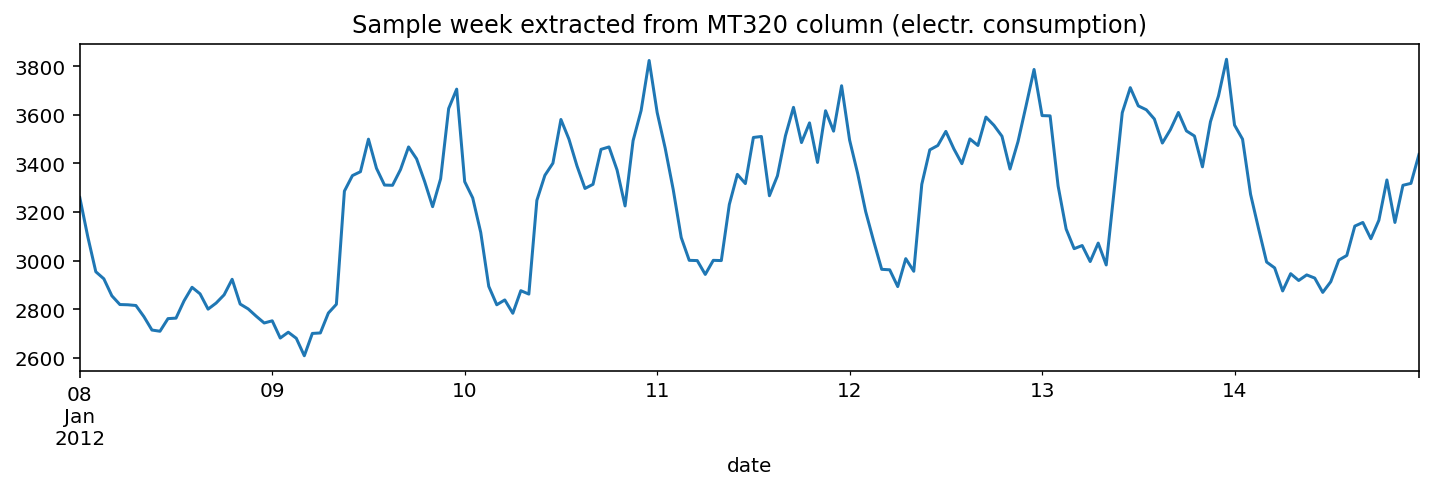

In [14]:
electr_df.set_index("date")[320][168:336].plot(title="Sample week extracted from MT320 column (electr. consumption)",
                                               figsize=(12,3));

#### Traffic dataset

> The raw data is in http://pems.dot.ca.gov. The data in this repo is a collection of 48 months (2015-2016) hourly data from the California Department of Transportation. The data describes the road occupancy rates (between 0 and 1) measured by different sensors on San Francisco Bay area freeways.

In [5]:
!ls data/aggr_data/

electricity.txt  electr_proc_data.csv  traffic.txt


In [10]:
traffic_df = pd.read_csv("data/aggr_data/traffic.txt", header=None)
traffic_df['date'] = pd.date_range(start='1/1/2015', periods=traffic_df.shape[0], freq="H")
traffic_df.to_csv("data/aggr_data/traffic_proc_data.csv") #to later use with library
# reorder columns
cols = traffic_df.columns.tolist() 
cols = cols[-1:] + cols[:-1]
traffic_df = traffic_df[cols]
# showing sample
traffic_df

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861
0,2015-01-01 00:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,0.0144,0.0098,0.0157,0.0216,0.0345,0.0545,0.0061,0.0279,0.0200,0.0128,0.0186,0.0097,0.0154,0.0267,0.0441,0.0320,0.0195,0.0169,0.0565,0.0336,0.0200,0.0208,0.0341,0.0457,0.0177,0.0236,0.0082,0.0496,0.0441,...,0.0236,0.0109,0.0216,0.0249,0.0206,0.0191,0.0143,0.0171,0.0156,0.0298,0.0229,0.0051,0.0097,0.0097,0.0079,0.0194,0.0038,0.0159,0.0239,0.0155,0.0180,0.0158,0.0205,0.0241,0.0172,0.0207,0.0332,0.0210,0.0079,0.0312,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,2015-01-01 01:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,0.0162,0.0114,0.0192,0.0239,0.0392,0.0870,0.0095,0.0279,0.0287,0.0134,0.0205,0.0073,0.0150,0.0338,0.0503,0.0424,0.0265,0.0183,0.0531,0.0397,0.0275,0.0265,0.0491,0.0502,0.0162,0.0258,0.0090,0.0573,0.0472,...,0.0311,0.0110,0.0259,0.0252,0.0228,0.0192,0.0147,0.0179,0.0170,0.0302,0.0252,0.0036,0.0073,0.0073,0.0058,0.0325,0.0052,0.0229,0.0256,0.0165,0.0214,0.0171,0.0100,0.0245,0.0151,0.0238,0.0446,0.0182,0.0058,0.0363,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,2015-01-01 02:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,0.0122,0.0074,0.0137,0.0153,0.0233,0.0735,0.0068,0.0163,0.0225,0.0069,0.0142,0.0068,0.0102,0.0237,0.0374,0.0359,0.0180,0.0103,0.0402,0.0385,0.0188,0.0193,0.0348,0.0405,0.0132,0.0171,0.0055,0.0543,0.0413,...,0.0246,0.0070,0.0144,0.0151,0.0148,0.0124,0.0089,0.0108,0.0110,0.0304,0.0235,0.0030,0.0068,0.0068,0.0050,0.0320,0.0036,0.0165,0.0243,0.0131,0.0146,0.0128,0.0084,0.0224,0.0092,0.0174,0.0334,0.0120,0.0050,0.0321,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,2015-01-01 03:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,0.0077,0.0060,0.0098,0.0082,0.0142,0.0424,0.0065,0.0083,0.0145,0.0042,0.0107,0.0070,0.0053,0.0172,0.0193,0.0224,0.0122,0.0060,0.0313,0.0329,0.0124,0.0144,0.0219,0.0349,0.0107,0.0108,0.0038,0.0330,0.0361,...,0.0156,0.0056,0.0095,0.0092,0.0088,0.0078,0.0059,0.0070,0.0068,0.0255,0.0208,0.0033,0.0070,0.0070,0.0052,0.0225,0.0028,0.0110,0.0228,0.0096,0.0108,0.0082,0.0079,0.0201,0.0054,0.0082,0.0208,0.0070,0.0052,0.0260,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,2015-01-01 04:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,0.0055,0.0053,0.0088,0.0036,0.0101,0.0253,0.0059,0.0062,0.0086,0.0025,0.0089,0.0116,0.0032,0.0153,0.0104,0.0166,0.0117,0.0036,0.0277,0.0293,0.0092,0.0131,0.0159,0.0344,0.0090,0.0088,0.0031,0.0250,0.0318,...,0.0093,0.0064,0.0074,0.0068,0.0038,0.0063,0.0051,0.0061,0.0059,0.0243,0.0216,0.0049,0.0116,0.0116,0.0071,0.0139,0.0024,0.0089,0.0220,0.0069,0.0067,0.0060,0.0073,0.0196,0.0035,0.0044,0.0137,0.0040,0.0071,0.0216,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2016-12-31 19:00:00,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,0.0403,0.0385,0.0686,0.0490,0.1153,0.0955,0.0478,0.0478,0.0618,0.0385,0.0478,0.0656,0.0360,0.1244,0.0276,0.0478,0.0563,0.0360,0.0360,0.0654,0.0579,0.0505,0.0721,0.0760,0.0240,0.0502,0.0353,0.0597,0.0472,...,0.0481,0.0478,0.0478,0.0000,0.0000,0.0430,0.0478,0.0444,0.0447,0.0360,0.0240,0.0317,0.0623,0.0441,0.0441,0.0506,0.0240,0.1048,0.0195,0.0454,0.0606,0.0416,0.0337,0.0204,0.0465,0.0476,0.0568,0.0538,0

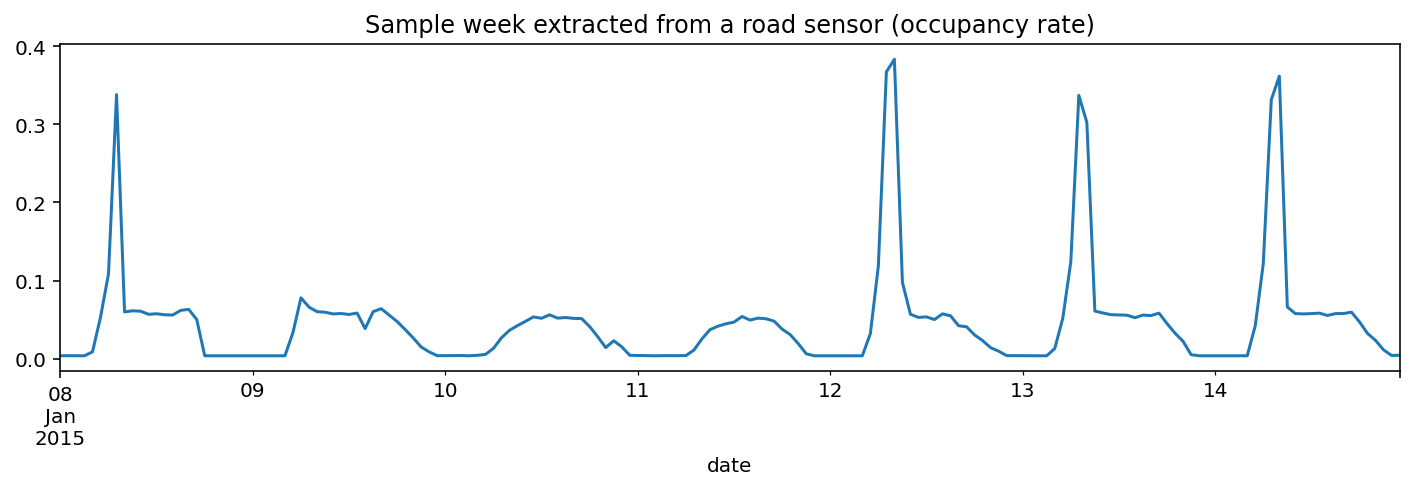

In [15]:
traffic_df.set_index("date")[0][168:336].plot(title="Sample week extracted from a road sensor (occupancy rate)",
                                              figsize=(12,3));

## Informer Model test with Electricity data

### Model definition

TODO: Ver código fuente [aquí](https://github.com/zhouhaoyi/Informer2020/blob/main/exp/exp_informer.py).

In [ ]:
args = dotdict()
args.data='custom'
args.root_path = "data/aggr_data/"
args.data_path = "electr_proc_data.csv"
#Note: data is automatically scaled

timeenc = 0 if args.embed!='timeF' else 1

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.target = '320'
args.freq = 'h' # hourly data (frequency)
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.checkpoints = './informer_checkpoints' # location of model checkpoints


args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 322 # encoder input size
args.dec_in = 322 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 8
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [ ]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

### Model Training and Evaluation

In [ ]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_{}_{}'\
          .format(args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, 
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, 
                  args.attn, args.factor, args.embed, args.distil, args.des, 1)

# set experiments
exp = Exp_Informer(args)

# train
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

# test
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_1>>>>>>>>>>>>>>>>>>>>>>>>>>
train 18293
val 2609
test 5237
	iters: 100, epoch: 1 | loss: 0.4039298
	speed: 0.1298s/iter; left time: 579.8677s
	iters: 200, epoch: 1 | loss: 0.1892719
	speed: 0.1272s/iter; left time: 555.5194s
	iters: 300, epoch: 1 | loss: 0.2115657
	speed: 0.1287s/iter; left time: 549.6062s
	iters: 400, epoch: 1 | loss: 0.1434193
	speed: 0.1297s/iter; left time: 540.5399s
	iters: 500, epoch: 1 | loss: 0.1859529
	speed: 0.1307s/iter; left time: 531.7986s
Epoch: 1 cost time: 73.92803859710693
Epoch: 1, Steps: 571 | Train Loss: 0.2320804 Vali Loss: 0.3250555 Test Loss: 0.5719498
Validation loss decreased (inf --> 0.325056).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2454157
	speed: 0.3558s/iter; left time: 1386.8745s
	iters: 200, epoch: 2 | loss: 0.1013235
	speed: 0.1315s/iter; left time: 499.3844s
	iters

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)
import numpy as np

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((5216, 24, 1), (5216, 24, 1))

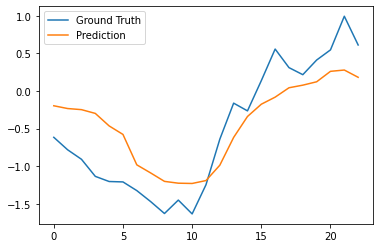

In [ ]:
# plot prediction
plt.figure()
plt.plot(trues[0,:-1], label='Ground Truth')
plt.plot(preds[0,:-1], label='Prediction')
plt.legend()
plt.show()

### Model and Forecasts Interpretation

In [ ]:
timeenc = 0 if args.embed!='timeF' else 1

shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='test',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
args.output_attention = True

exp = Exp_Informer(args)

model = exp.model
setting = "informer_custom_ftMS_sl96_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_1"
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [ ]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [ ]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 4, 96, 96]), torch.Size([1, 4, 49, 49]))

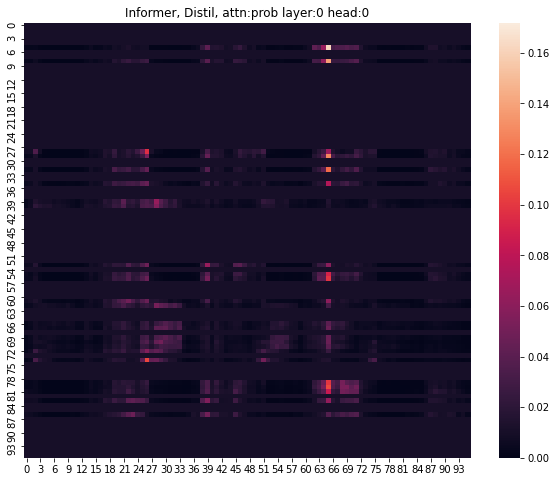

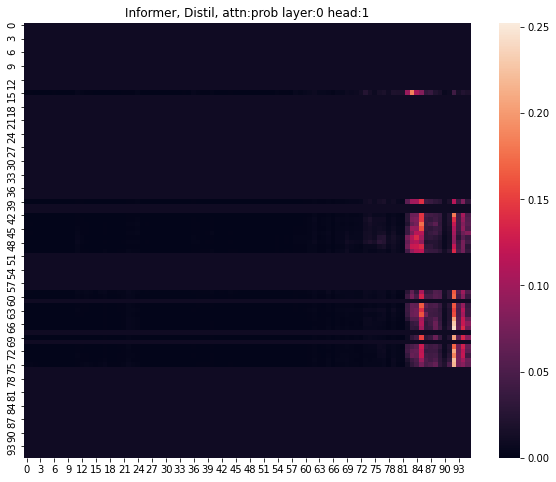

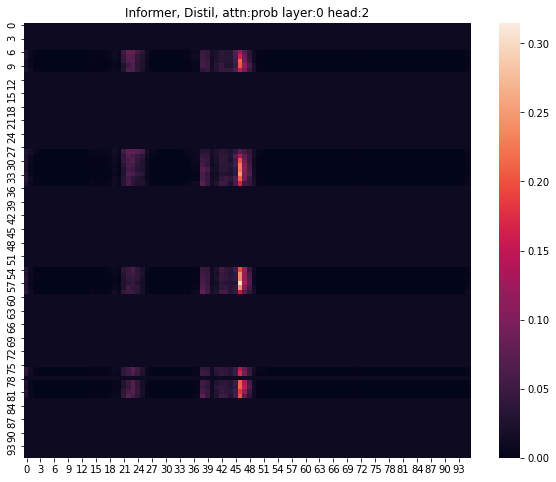

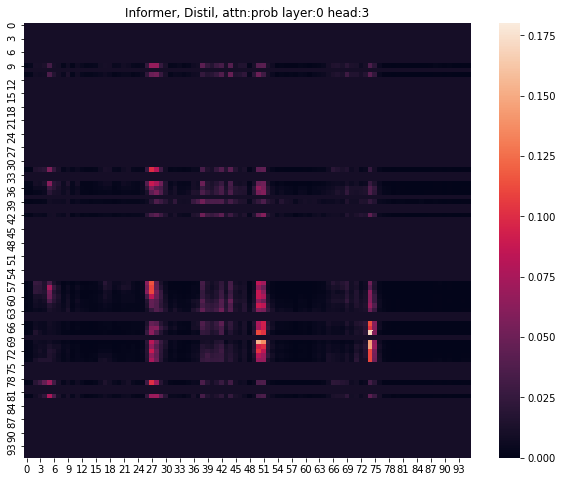

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

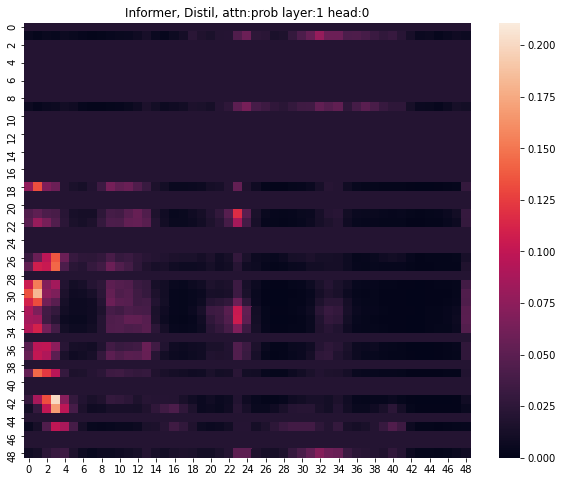

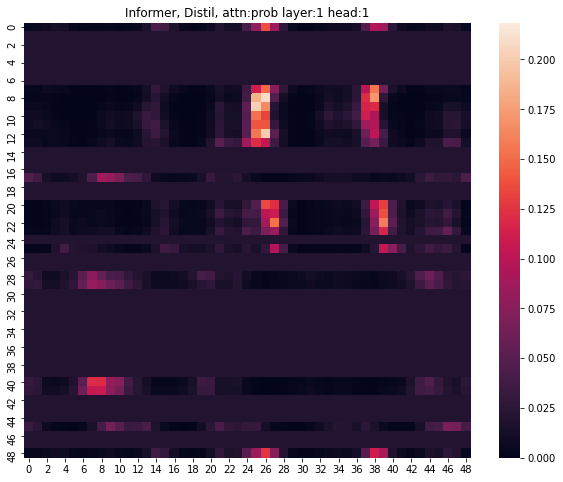

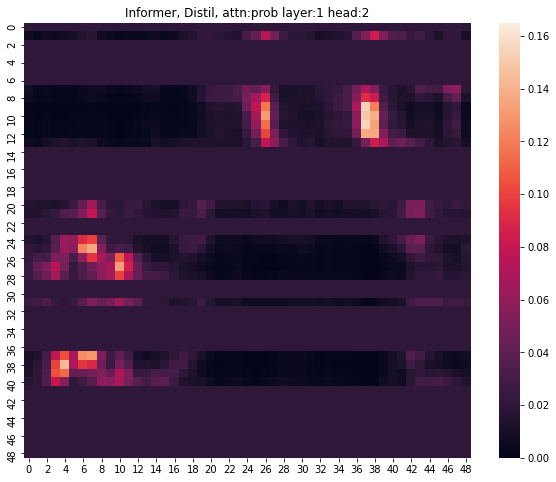

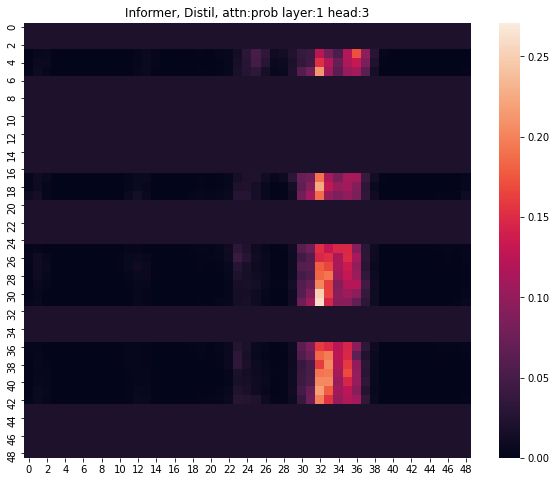

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

In [ ]:
# TODO: Comment and review further

## Informer Model test with Traffic data

### Model definition

In [19]:
args = dotdict()
args.data='custom'
args.root_path = "data/aggr_data/"
args.data_path = "traffic_proc_data.csv"
#Note: data is automatically scaled

timeenc = 0 if args.embed!='timeF' else 1

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.target = '861'
args.freq = 'h' # hourly data (frequency)
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.checkpoints = tfm_path+'Informer2020/informer_checkpoints' # location of model checkpoints


args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 863 # encoder input size
args.dec_in = 863 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 8
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [20]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

### Model Training and Evaluation

In [21]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_{}_{}'\
          .format(args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, 
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, 
                  args.attn, args.factor, args.embed, args.distil, args.des, 1)

# set experiments
exp = Exp_Informer(args)

# train
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

# test
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_1>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12161
val 1733
test 3485
	iters: 100, epoch: 1 | loss: 0.1749483
	speed: 0.1426s/iter; left time: 419.4587s
	iters: 200, epoch: 1 | loss: 0.0952069
	speed: 0.1417s/iter; left time: 402.6545s
	iters: 300, epoch: 1 | loss: 0.0581998
	speed: 0.1428s/iter; left time: 391.4672s
Epoch: 1 cost time: 54.358001947402954
Epoch: 1, Steps: 380 | Train Loss: 0.1785995 Vali Loss: 0.1610553 Test Loss: 0.3590620
Validation loss decreased (inf --> 0.161055).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0533578
	speed: 0.3736s/iter; left time: 956.8457s
	iters: 200, epoch: 2 | loss: 0.0677164
	speed: 0.1486s/iter; left time: 365.7901s
	iters: 300, epoch: 2 | loss: 0.0990865
	speed: 0.1480s/iter; left time: 349.3561s
Epoch: 2 cost time: 56.22327184677124
Epoch: 2, Steps: 380 | Train Loss: 0.0590417 Vali L

In [22]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((3456, 24, 1), (3456, 24, 1))

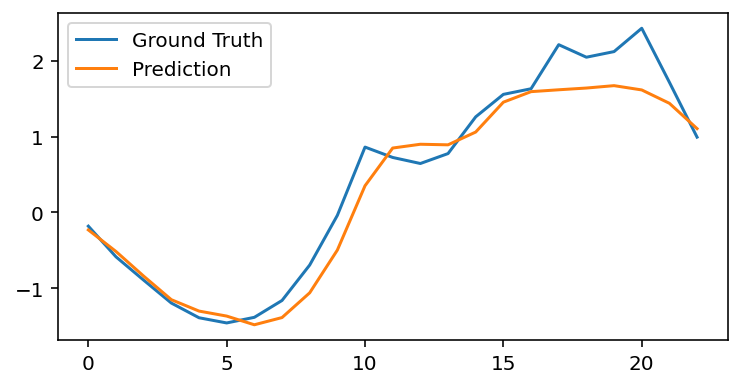

In [31]:
# plot prediction
plt.figure(figsize=(6,3))
plt.plot(trues[0,:-1], label='Ground Truth')
plt.plot(preds[0,:-1], label='Prediction')
plt.legend()
plt.show()

### Model and Forecasts Interpretation

In [32]:
timeenc = 0 if args.embed!='timeF' else 1

shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='test',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [37]:
args.output_attention = True

exp = Exp_Informer(args)

model = exp.model
setting = "informer_custom_ftMS_sl96_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_1"
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [38]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [39]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 4, 96, 96]), torch.Size([1, 4, 49, 49]))

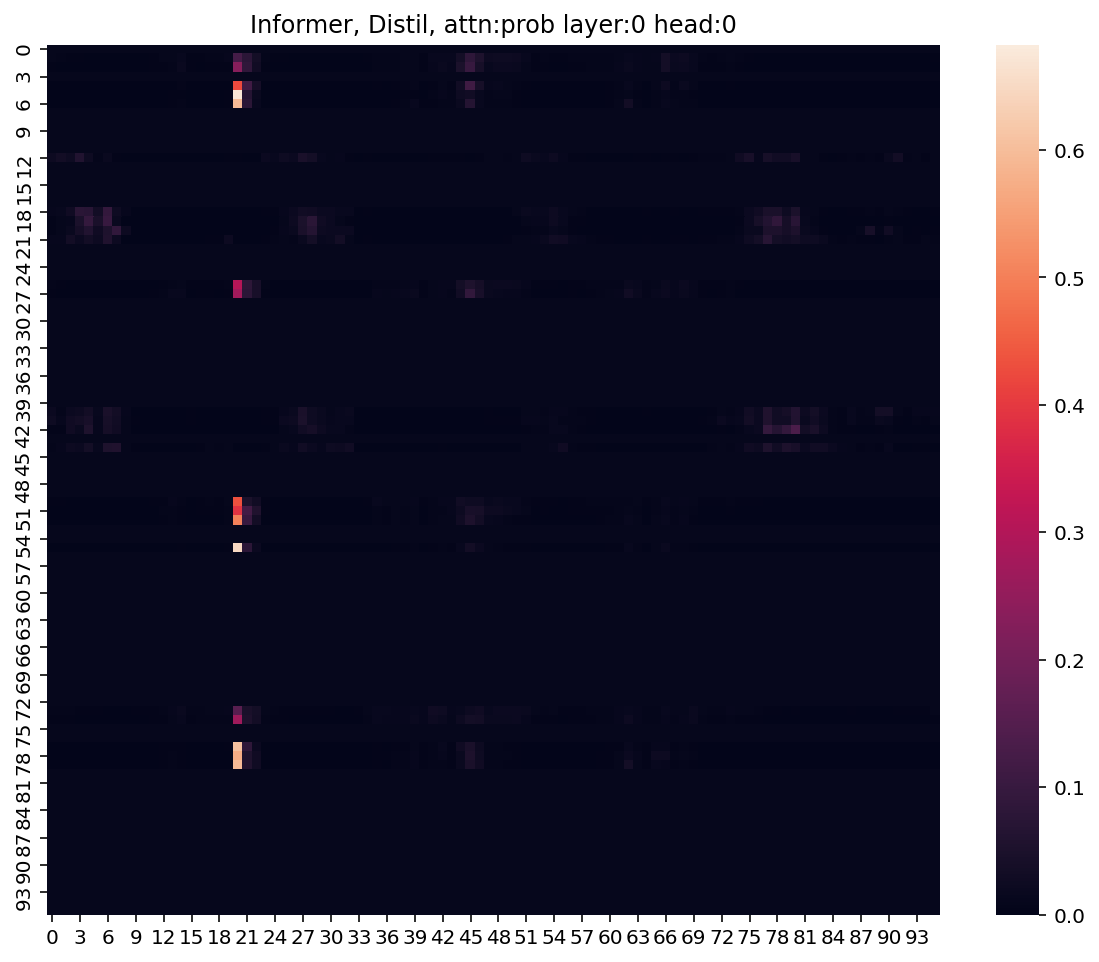

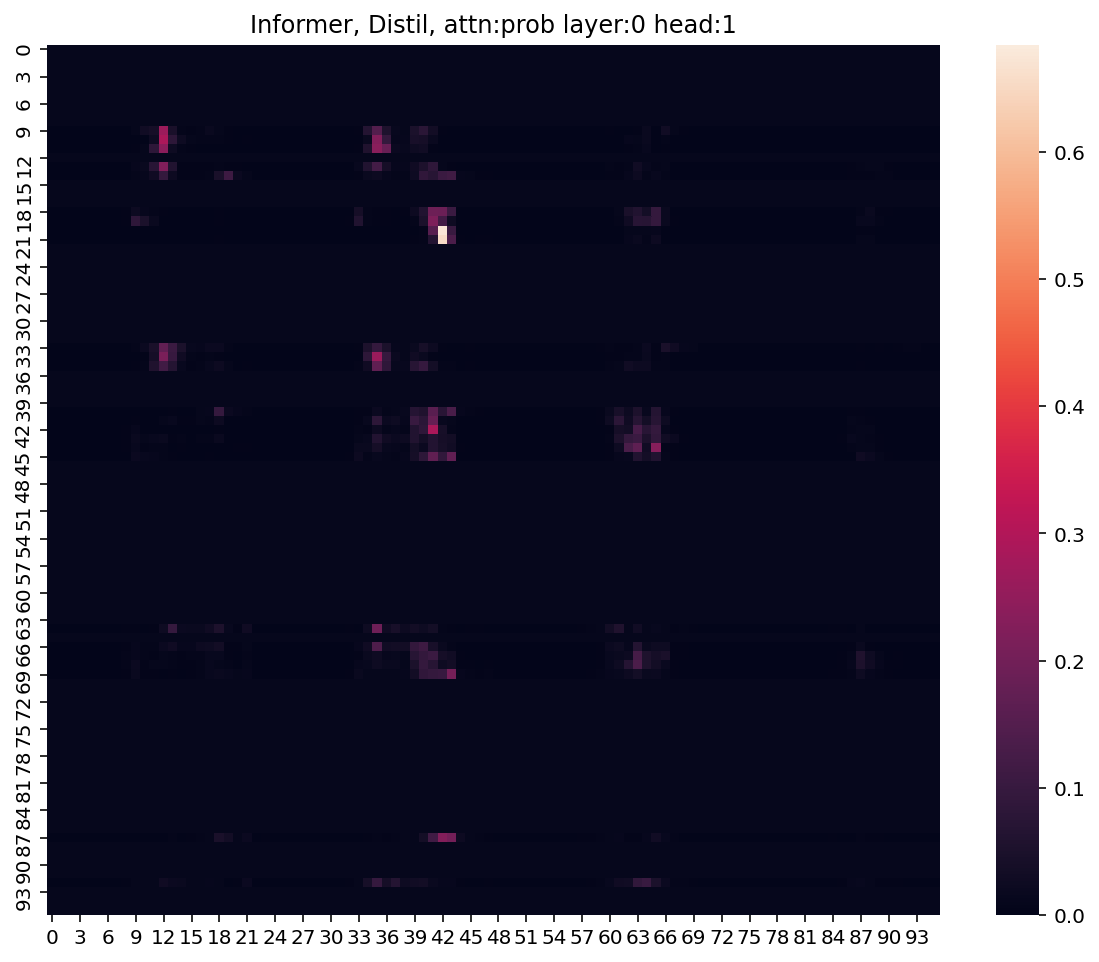

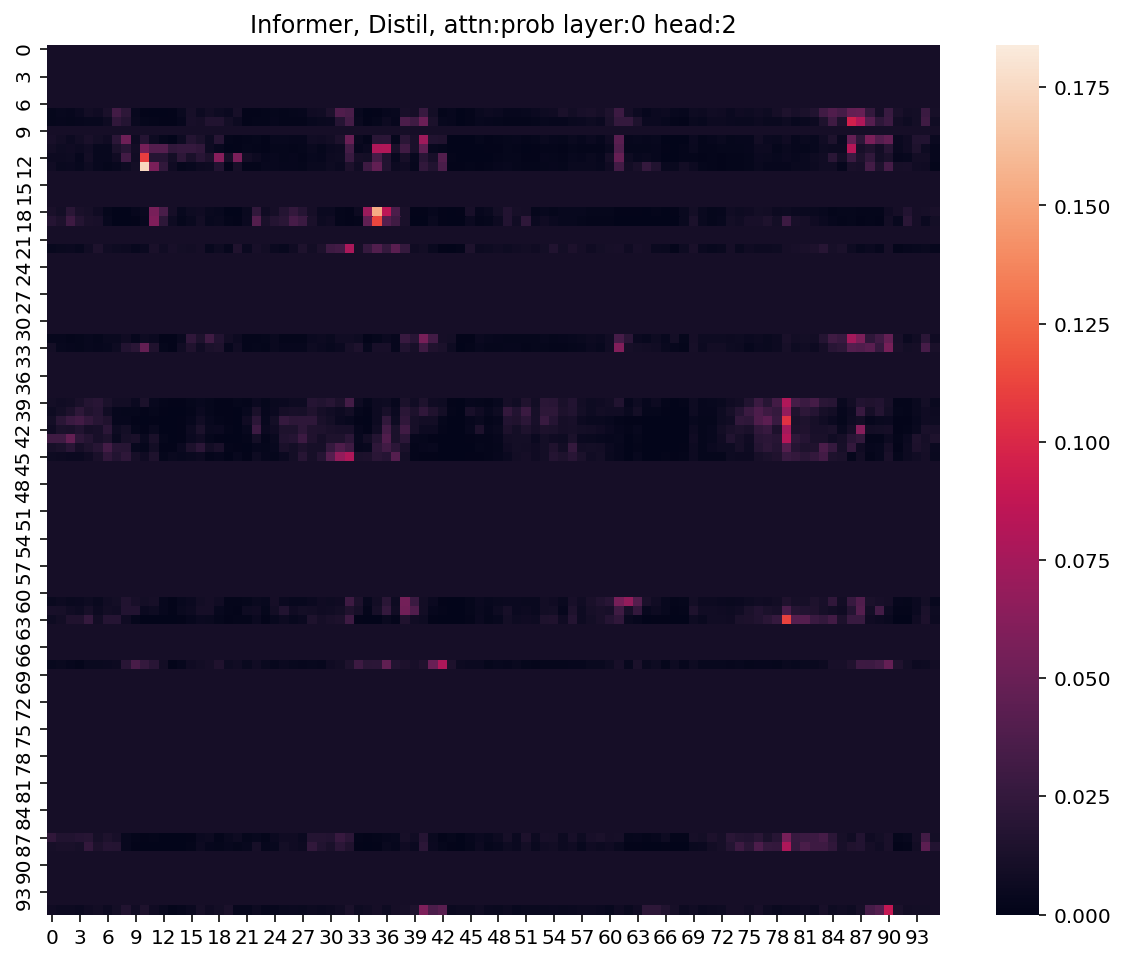

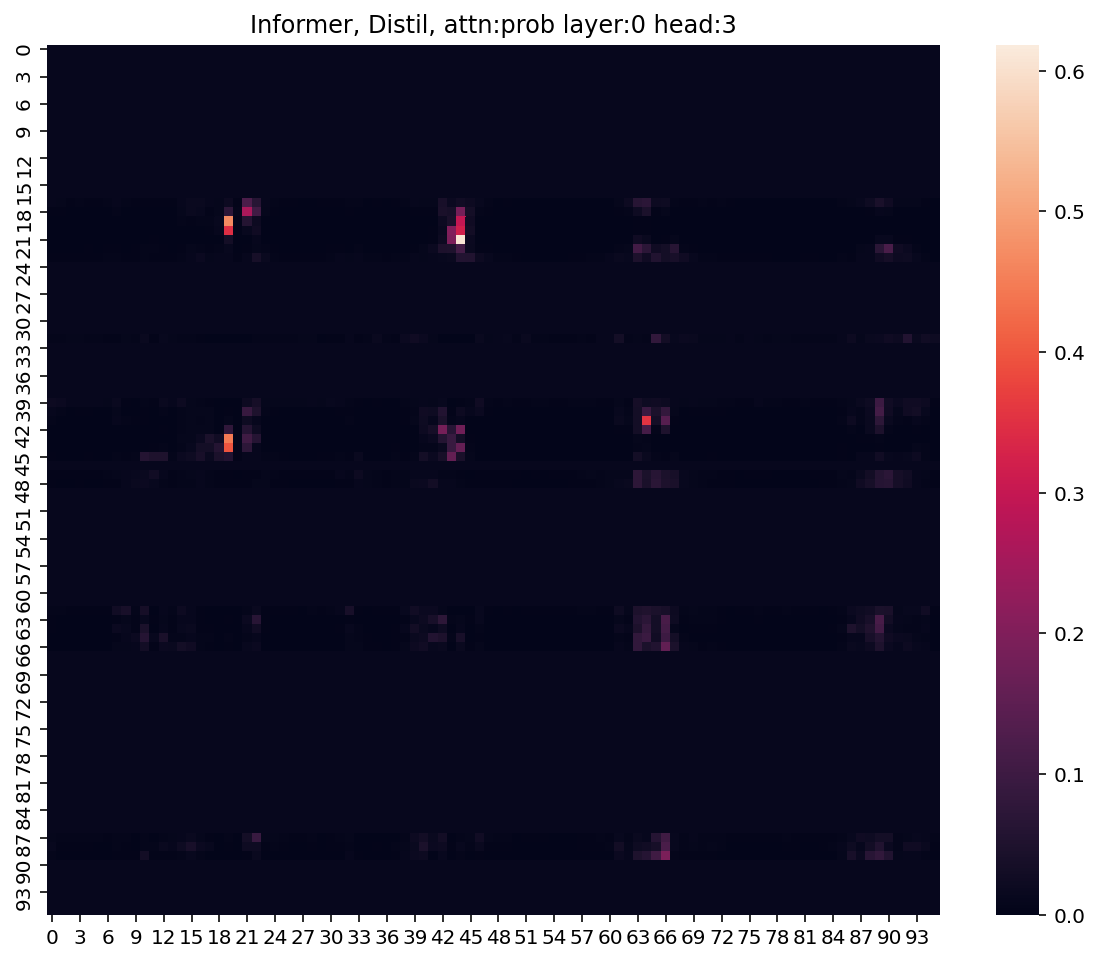

In [40]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

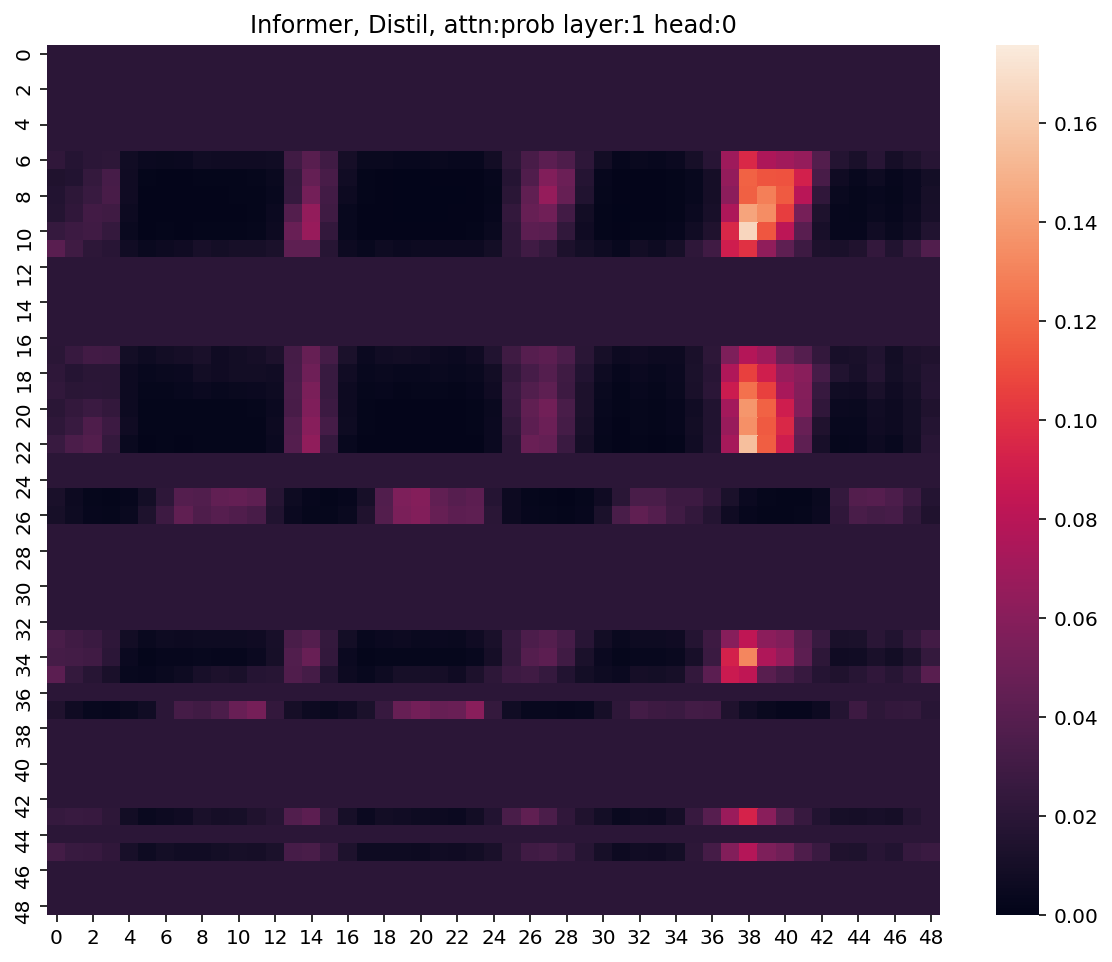

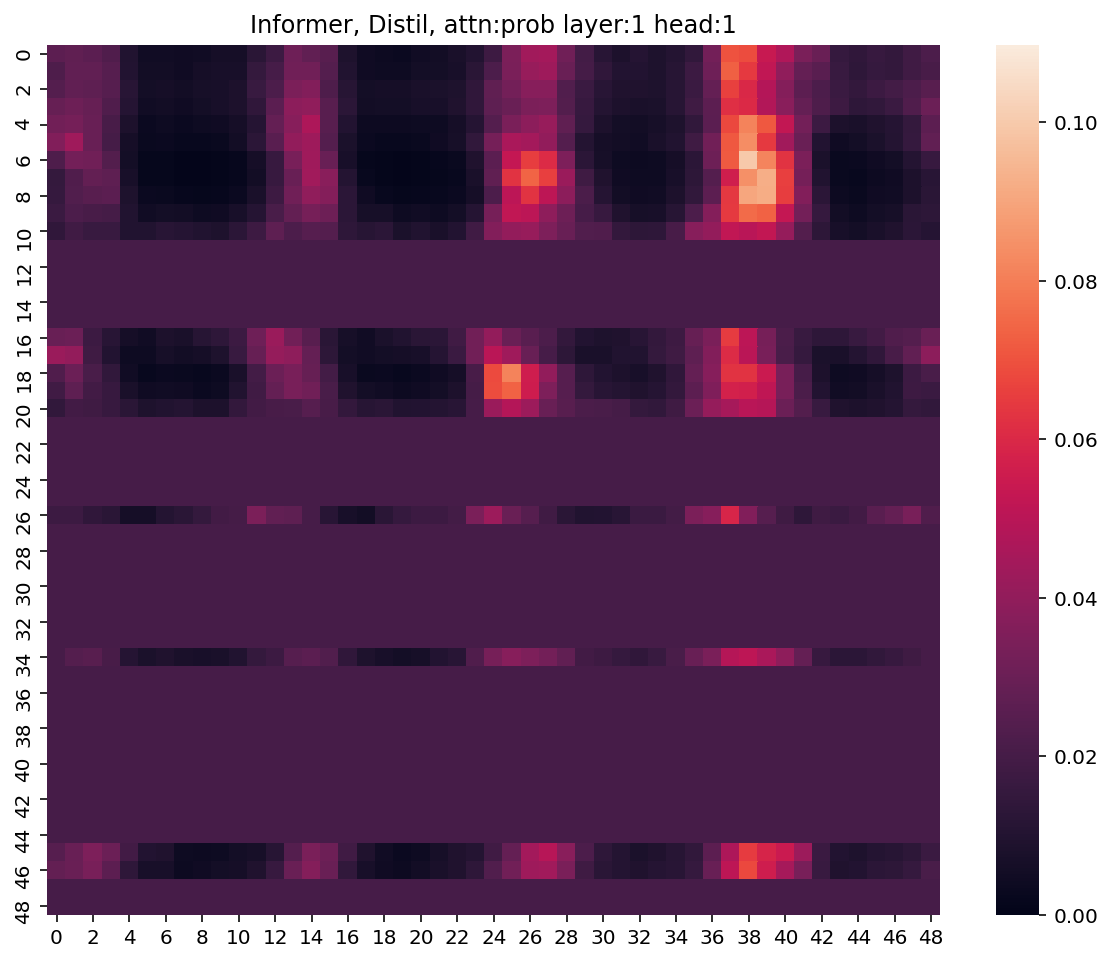

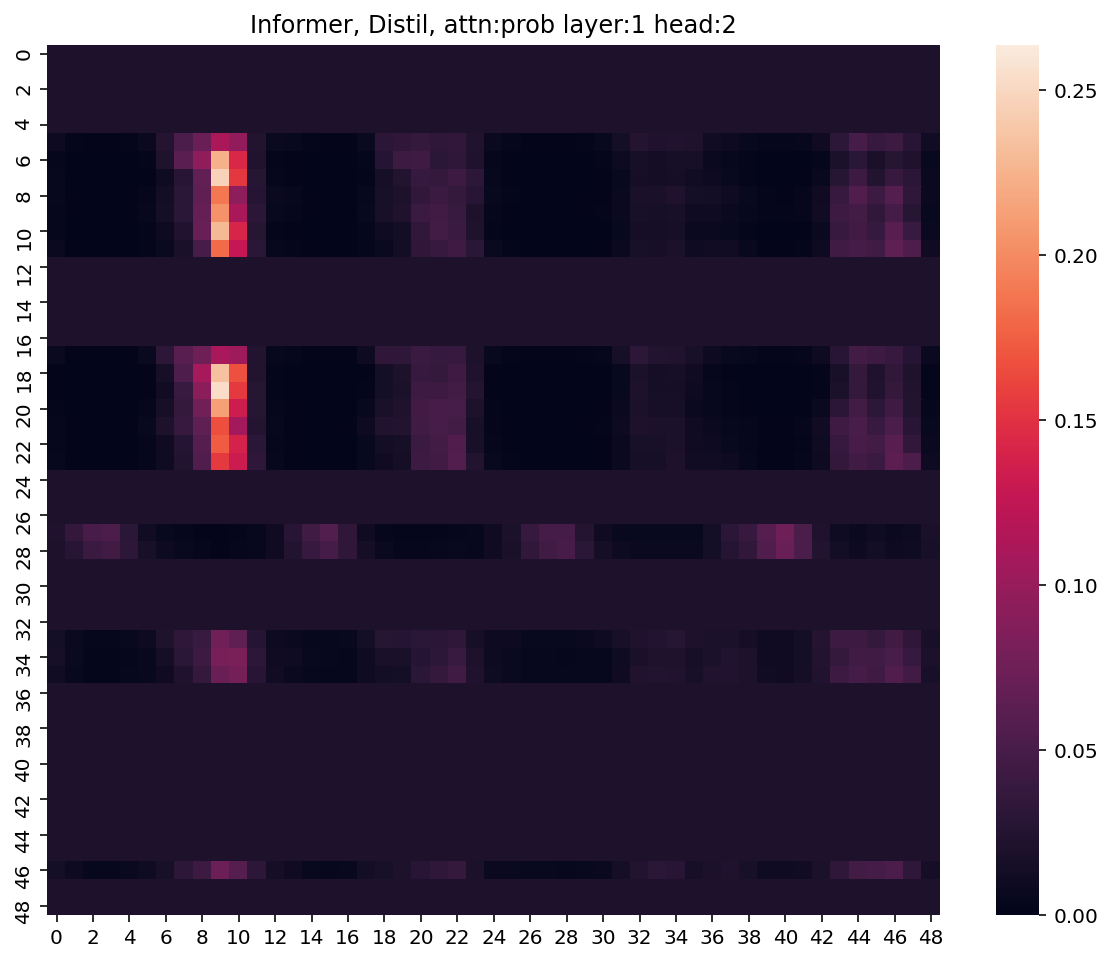

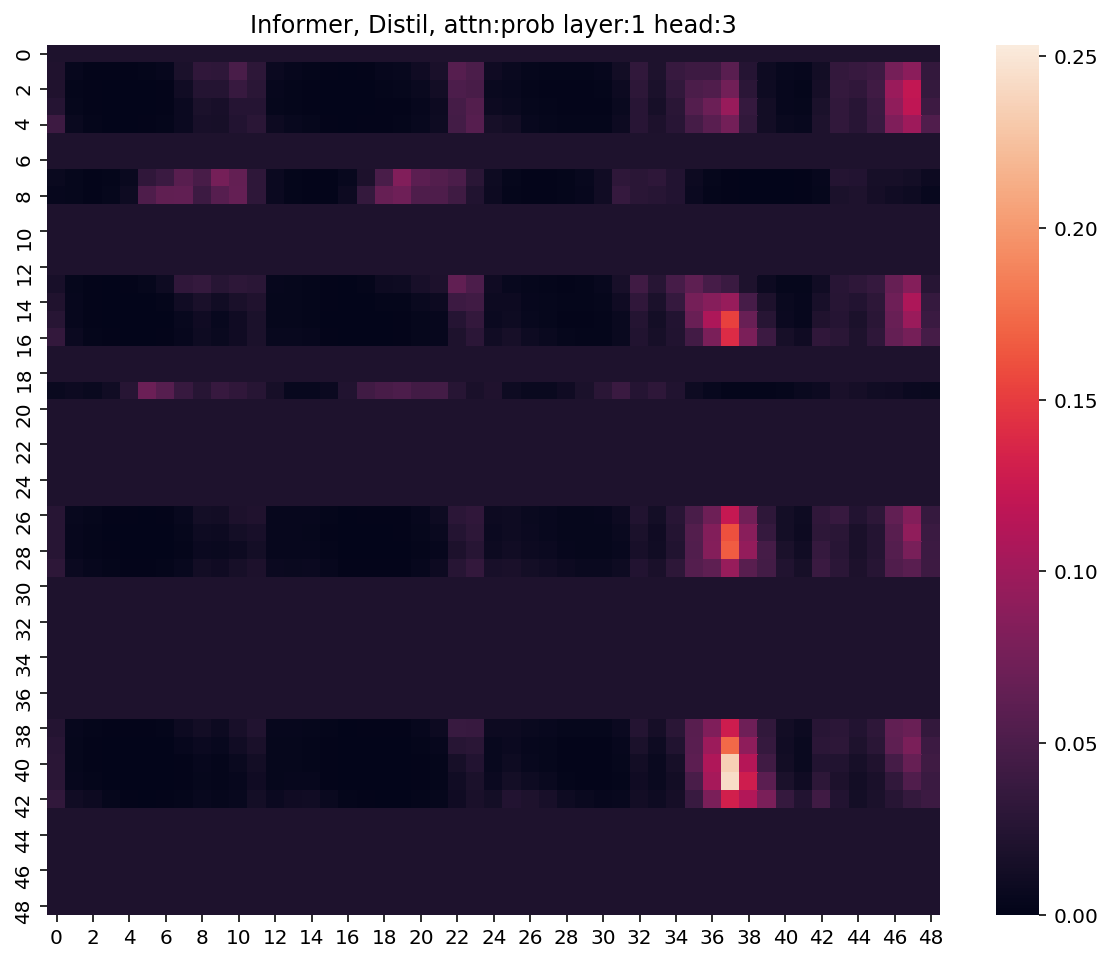

In [41]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()